## Conflict and Movement in Syria, 2019-2020
### UIUC, iSchool, IS590PR, Spring 2020, Final Project
#### By Derek Harootune Otis
---

This project analyzes the movement of internally displaced persons within Syria in relation to the ebb and flow of Syria's ongoing civil war.

### Part One: Preparation

#### Term Definitions
---
**Internally Displaced Person (IDP)** - "\[P\]ersons or groups of persons who have been forced or obliged to flee or to leave
their homes or places of habitual residence, in particular as a result of or in order
to avoid the effects of armed conflict, situations of generalized violence, violations
of human rights or natural or human-made disasters, and who have not crossed an
internationally recognized state border." Definition from the [OCHA Guiding Principles on Internal Displacement](https://www.internal-displacement.org/sites/default/files/publications/documents/199808-training-OCHA-guiding-principles-Eng2.pdf)

**IDP Movement** - The number of individuals forced to move from a place of origin to a new place. Counts of IDP movement are extracted from OCHA Turkey's "Syrian Arab Republic: IDP movements and IDP spontaneous return movements Data" dataset (see below)

**Conflict Event** - A single conflict-related observation as recorded in the ACLED's "Syrian Arab Republic - Conflict Data" dataset (see below)

#### Datasets
---
1. [Syrian Arab Republic: IDP movements and IDP spontaneous return movements Data](https://data.humdata.org/dataset/syrian-arab-republic-idp-movements-and-idp-spontaneous-return-movements-data)
2. [Syrian Arab Republic - Conflict Data](https://data.humdata.org/dataset/acled-data-for-syrian-arab-republic)

#### Hypotheses
---

*Setting the stage - imports, data processing - DISCUSS THIS FURTHER

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

DATE_CODES = ['2019-1', '2019-2', '2019-3', '2019-4', '2019-5', '2019-6', '2019-7', '2019-8', '2019-9', '2019-10',
          '2019-11', '2019-12', '2020-1', '2020-2']

DISTRICTS = ["Aleppo", "Al-Hasakeh", "Ar-Raqqa", "As-Sweida", "Damascus", "Dar'a", "Deir-ez-Zor",
             "Hama", "Homs", "Idleb", "Lattakia", "Quneitra", "Rural Damascus", "Tartous"]


# Data preprocessing - this is unavoidable due to the sheer variability of the source data files
## preprocess conflict data
conflict_data_path = Path('data/conflict_data_syr.csv')
conflict_data = pd.read_csv(conflict_data_path, index_col='data_id')

### Date processing
conflict_data['event_date'] = pd.to_datetime(conflict_data['event_date'])
conflict_data['month'] = conflict_data.apply(lambda row: row['event_date'].month, axis=1)
conflict_data['month'] = conflict_data['month'].astype(str)
conflict_data['year'] = conflict_data['year'].astype(str)
conflict_data['date_code'] = conflict_data['year'] + '-' + conflict_data['month']


## preprocess IDP movement data
idp_data_paths = ['data/01_idp_jan_19.xlsx', 'data/02_idp_feb_19.xlsm', 'data/03_idp_mar_19.xlsm',
                  'data/04_idp_apr_19.xlsm', 'data/05_idp_may_19.xlsm', 'data/06_idp_jun_19.xlsm',
                  'data/07_idp_jul_19.xlsm', 'data/08_idp_aug_19.xlsx', 'data/09_idp_sep_19.xlsx',
                  'data/10_idp_oct_19.xlsx', 'data/11_idp_nov_19.xlsx', 'data/12_idp_dec_19.xlsx',
                  'data/13_idp_jan_20.xlsx', 'data/14_idp_feb_20.xlsx']
idp_data = pd.DataFrame(index=DISTRICTS + ["Unknown", "Grand Total"])

for i in range(len(idp_data_paths)):
    path = idp_data_paths[i]
    month_data = pd.read_excel(path, sheet_name='Table-Origin_vs_Departure', index_col='Origin')["Grand Total"]
    idp_data = idp_data.join(month_data, rsuffix=str(i))

### re-label columns and drop unknown
idp_data = idp_data.drop(labels='Unknown')  # TODO: DON'T FORGET TO MENTION THAT THIS IS BEING DROPPED
idp_data.columns = DATE_CODES

#### Function Definitions

With the above preprocessing complete, we can define useful utility functions for filtering and finding correlations between various aspects of the two datasets. Below we define two functions to filter our data based on governorate and event type, and another to produce a correlation matrix of the two filtered variables.

In [2]:
def extract_conflict_data(conflict_data: pd.DataFrame, admin_district: str, event_type: str):
    """

    :param conflict_data:
    :param admin_district:
    :param event_type:
    :return:
    """
    # Stacking and unstacking inspired by this post: https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values

    if admin_district and event_type:
        extracted_conflict_data = conflict_data.groupby(['admin1', 'event_type', 'date_code']).count()['iso'].unstack(fill_value=0).stack()
        extracted_conflict_data = extracted_conflict_data.loc[admin_district, event_type].loc[DATE_CODES]
    elif admin_district:
        extracted_conflict_data = conflict_data.groupby(['admin1', 'date_code']).count()['iso'].unstack(fill_value=0).stack()
        extracted_conflict_data = extracted_conflict_data.loc[admin_district].loc[DATE_CODES]
    elif event_type:
        extracted_conflict_data = conflict_data.groupby(['event_type', 'date_code']).count()['iso'].unstack(fill_value=0).stack()
        extracted_conflict_data = extracted_conflict_data.loc[event_type].loc[DATE_CODES]
    else:
        extracted_conflict_data = conflict_data.groupby(['date_code']).count()['iso']
        extracted_conflict_data = extracted_conflict_data.loc[DATE_CODES]

    return pd.DataFrame(extracted_conflict_data)


def extract_idp_data(idp_data: pd.DataFrame, admin_district: str) -> pd.DataFrame:
    """

    :param idp_data:
    :param admin_district:
    :return:
    """

    if admin_district:
        extracted_idp_data = idp_data.loc[admin_district]
    else:
        extracted_idp_data = idp_data.loc['Grand Total']

    return extracted_idp_data



def calculate_conflict_movement_correlation(conflict_data: pd.DataFrame, idp_data: pd.DataFrame,
                                            event_type: str = '', admin_district: str = '', delta: bool = False):
    """

    :param conflict_data:
    :param idp_data:
    :param event_type:
    :param admin_district:
    :param delta:
    :return:
    """
    extracted_conflict_data = extract_conflict_data(conflict_data, admin_district, event_type)
    extracted_idp_data = extract_idp_data(idp_data, admin_district)
    corr_frame = extracted_conflict_data.join(extracted_idp_data)
    if delta:
        corr_frame = corr_frame.pct_change()
        corr_frame = corr_frame.drop(labels='2019-1')

    labels = {'iso': 'conflict', 'Grand Total': 'movement'}
    corr_frame = corr_frame.corr().rename(columns=labels, index=labels)

    return corr_frame

### Part Two: Data Exploration and Analysis

#### Initial Hypothesis Testing
Our initial testing uses the broadest possible scope, calculating the correlation between, in the first case, overall movement numbers and overall conflict numbers by month, and in the second case the percent change in these totals by month.

In [ ]:
corr_raw_counts = calculate_conflict_movement_correlation(conflict_data, idp_data).loc['conflict']['movement']
corr_deltas = calculate_conflict_movement_correlation(conflict_data, idp_data, delta=True).loc['conflict']['movement']

print(f'Pearson\'s r correlation between raw conflict event and IDP movement counts by month:\n{round(corr_raw_counts, 4)}')
print(f'Pearson\'s r correlation between % change in conflict event and IDP movement counts by month:\n{round(corr_deltas, 4)}')

We find that neither correlation suggests a particularly strong relationship between the two variables, supporting the null hypotheses.

NOTE: From this point onward, calculation of correlation will be done based on percent change of variables by month. Raw counts are presented here for the sake of comparison

#### Digging Deeper - Correlation of Conflict and Movement by Governorate

Though comparing change in grand totals does not reveal any clear relationship between change in conflict and change in movement, our statistical picture of the situation becomes much more complex once we investigate the correlation between these two variables by governorate. 

In [ ]:
    corr_bar = pd.DataFrame(index=DISTRICTS, columns=['correlation'])

    for district in DISTRICTS:
        corr_bar.loc[district] = calculate_conflict_movement_correlation(conflict_data, idp_data, event_type='', admin_district=district, delta=True).loc[district][0]

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(DISTRICTS)), corr_bar['correlation'].fillna(0).values, tick_label=DISTRICTS, align='center')
    plt.xticks(rotation='vertical')
    plt.xlabel('Governorate')
    plt.ylabel('Correlation')
    plt.suptitle('Correlation of Conflict delta and Movement delta by Governorate')
    plt.show()

In fact, we see a wide variety of different relationships represented at this level of detail. This suggests the presence of one or more external variables, which may or may not be captured in the source datasets of this analysis, which affect the degree to which conflict and movement are related - or, perhaps, exert some effect on conflict and movement such that the two appear correlated in some cases, and appear unrelated in others.

#### Geographic and Political Commonalities
One potential set of relevant external variables is the geographical distribution of the territories of various factions within Syria, during the period studied by this analysis. A conflict map of Syria as of September 2019 (the first month for which we can calculate percent change in IDP movement data) is reproduced below (map courtesy of [polgeonow](www.polgeonow.com)).

![alt text](https://1.bp.blogspot.com/-M1NO-ELPqYA/XXssPUmFShI/AAAAAAAAC3c/p1HZwbNvI6shfXuq_qhAvmZqYwSI8ULXACLcBGAsYHQ/s1600/2019-09-10_syria-control-map-kurds-isis-rebels.jpg "A map of Syria as of September 2019")

As has been the case for the majority of the Civil War following the large-scale retreat of ISIS/ISIL (including the present day), the greater part of non-Assad-government forces' territories are concentrated in the North of the country. Interestingly, many of the governorates who exhibit a strong positive correlation between change in conflict and movement are also concentrated in the North. Many were either completely or partially controlled by non-Assad-government forces, were recently under such control, or were contested during the period of time studied in this analysis.

To specifically illustrate the geographical aspect of this coincidence, let us extract only those districts who exhibited a positive correlation between change in conflict and movement.

In [ ]:
positive_corr_bar = corr_bar.query('correlation > 0')

positive_corr_districts = [district for district in DISTRICTS if district in positive_corr_bar.index]

plt.close()
plt.bar(range(len(positive_corr_districts)), positive_corr_bar['correlation'].fillna(0).values, tick_label=positive_corr_districts, align='center')
plt.xticks(rotation='vertical')
plt.xlabel('Governorate')
plt.ylabel('Correlation')
plt.suptitle('Positive Correlations of Conflict delta and Movement delta by Governorate')
plt.show()

Mapped on a simple outline border map of Syria's governorates (map courtesy of [d-maps](https://d-maps.com/carte.php?num_car=56601&lang=en)):

![alt text](./img/syria.png "Map of syria with positive correlation governorates marked in pink")

In [3]:
Mapped on a simple outline border map of Syria's governorates (map courtesy of [d-maps](https://d-maps.com/carte.php?num_car=56601&lang=en)):

![alt text](./img/syria.png "Map of syria with positive correlation governorates marked in pink")

Pearson's r correlation between raw conflict event and IDP movement counts by month:
-0.0973
Pearson's r correlation between % change in conflict event and IDP movement counts by month:
0.0834


We find that neither correlation suggests a particularly strong relationship between the two variables, supporting the null hypotheses.

NOTE: From this point onward, calculation of correlation will be done based on percent change of variables by month. Raw counts are presented here for the sake of comparison

#### Digging Deeper - Correlation of Conflict and Movement by Governorate

Though comparing change in grand totals does not reveal any clear relationship between change in conflict and change in movement, our statistical picture of the situation becomes much more complex once we investigate the correlation between these two variables by governorate. 

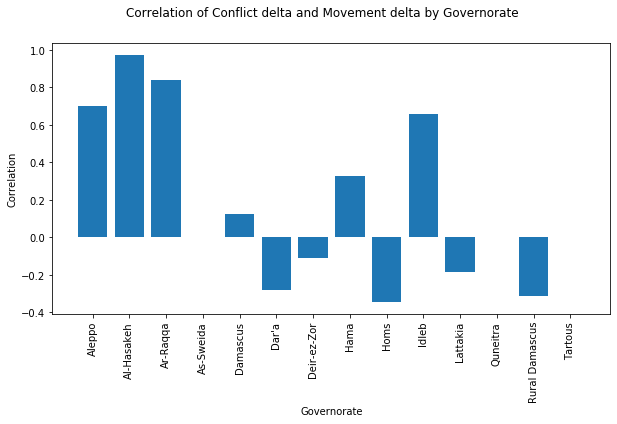

In [11]:
    corr_bar = pd.DataFrame(index=DISTRICTS, columns=['correlation'])

    for district in DISTRICTS:
        corr_bar.loc[district] = calculate_conflict_movement_correlation(conflict_data, idp_data, event_type='', admin_district=district, delta=True).loc[district][0]

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(DISTRICTS)), corr_bar['correlation'].fillna(0).values, tick_label=DISTRICTS, align='center')
    plt.xticks(rotation='vertical')
    plt.xlabel('Governorate')
    plt.ylabel('Correlation')
    plt.suptitle('Correlation of Conflict delta and Movement delta by Governorate')
    plt.show()

In fact, we see a wide variety of different relationships represented at this level of detail. This suggests the presence of one or more external variables, which may or may not be captured in the source datasets of this analysis, which affect the degree to which conflict and movement are related - or, perhaps, exert some effect on conflict and movement such that the two appear correlated in some cases, and appear unrelated in others.

#### Geographic and Political Commonalities
One potential set of relevant external variables is the geographical distribution of the territories of various factions within Syria, during the period studied by this analysis. A conflict map of Syria as of September 2019 (the first month for which we can calculate percent change in IDP movement data) is reproduced below (map courtesy of [polgeonow](www.polgeonow.com)).

![alt text](https://1.bp.blogspot.com/-M1NO-ELPqYA/XXssPUmFShI/AAAAAAAAC3c/p1HZwbNvI6shfXuq_qhAvmZqYwSI8ULXACLcBGAsYHQ/s1600/2019-09-10_syria-control-map-kurds-isis-rebels.jpg "A map of Syria as of September 2019")

As has been the case for the majority of the Civil War following the large-scale retreat of ISIS/ISIL (including the present day), the greater part of non-Assad-government forces' territories are concentrated in the North of the country. Interestingly, many of the governorates who exhibit a strong positive correlation between change in conflict and movement are also concentrated in the North. Many were either completely or partially controlled by non-Assad-government forces, were recently under such control, or were contested during the period of time studied in this analysis.

To specifically illustrate the geographical aspect of this coincidence, let us extract only those districts who exhibited a positive correlation between change in conflict and movement.

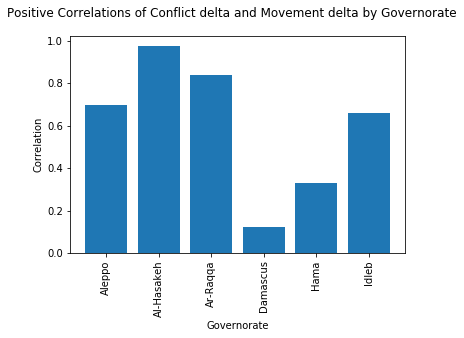

In [14]:
positive_corr_bar = corr_bar.query('correlation > 0')

positive_corr_districts = [district for district in DISTRICTS if district in positive_corr_bar.index]

plt.close()
plt.bar(range(len(positive_corr_districts)), positive_corr_bar['correlation'].fillna(0).values, tick_label=positive_corr_districts, align='center')
plt.xticks(rotation='vertical')
plt.xlabel('Governorate')
plt.ylabel('Correlation')
plt.suptitle('Positive Correlations of Conflict delta and Movement delta by Governorate')
plt.show()

Mapped on a simple outline border map of Syria's governorates (map courtesy of [d-maps](https://d-maps.com/carte.php?num_car=56601&lang=en)):

![alt text](./img/syria.png "Map of syria with positive correlation governorates marked in pink")